In [ ]:
import os
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop,Adam,AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap

In [20]:
data = 'brain2/Training'
categories = ['glioma','meningioma','notumor','pituitary']
folds = [os.path.join(data, catg) for catg in categories]
folds

['brain2/Training\\glioma',
 'brain2/Training\\meningioma',
 'brain2/Training\\notumor',
 'brain2/Training\\pituitary']

In [21]:
def img_array_dim_all(folds, categories):
    for idx, folder in enumerate(folds):
        for img in os.listdir(folder):
            img_path = os.path.join(folder, img)
            img_array = cv2.imread(img_path)
            if img_array is not None:
                print(f"Category: {categories[idx]}")
                print(f"Dim: {img_array.shape}")
                print("-------------------")
                print(img_array)
                print("\n")
                break
data = "brain2/Training"
categories = os.listdir(data)
folds = [os.path.join(data, catg) for catg in categories]

img_array_dim_all(folds, categories)

Category: glioma
Dim: (512, 512, 3)
-------------------
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


Category: meningioma
Dim: (512, 512, 3)
-------------------
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


Category: notumor
Dim: (350, 350, 3)
---------------

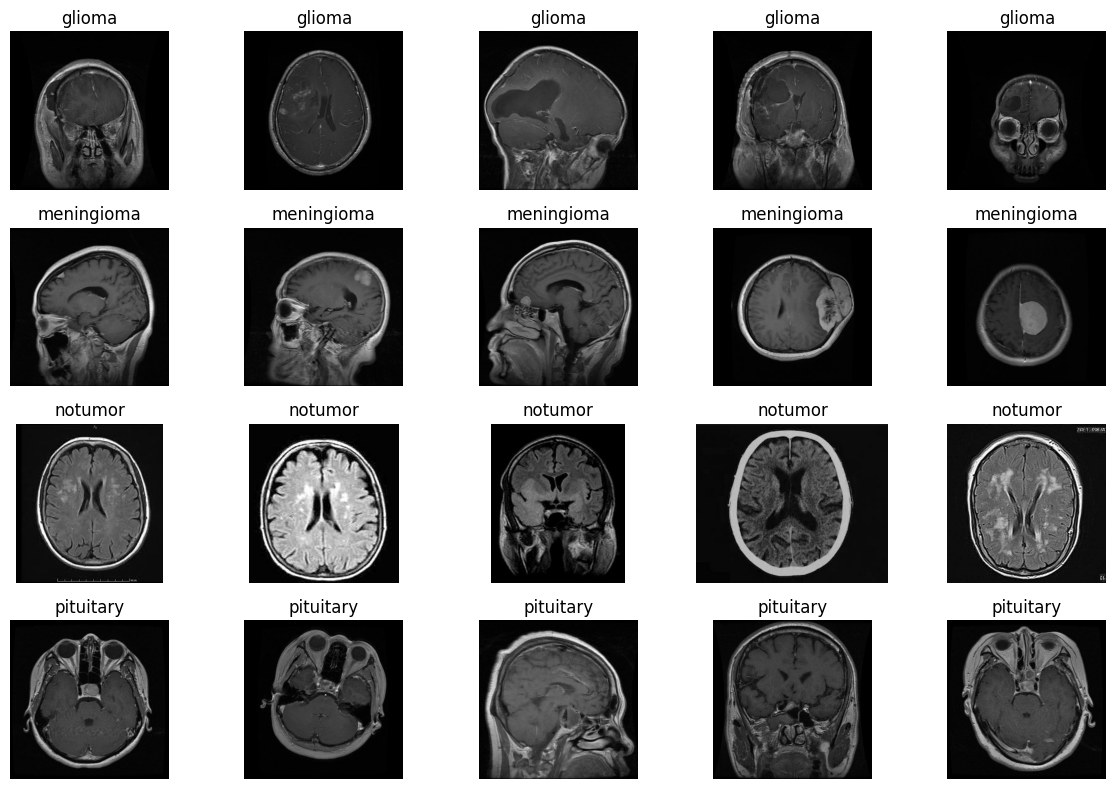

In [22]:
samples_per_class = 5  

plt.figure(figsize=(12, 8))
for idx, category in enumerate(categories):
    folder_path = os.path.join(data, category)
    images = os.listdir(folder_path)
    sample_imgs = random.sample(images, min(samples_per_class, len(images)))
    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(categories), samples_per_class, idx*samples_per_class + i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(category)
plt.tight_layout()
plt.show()

Preprocessing

In [23]:
img_size = 224
X = []
y = []
for idx, category in enumerate(categories):
    folder = os.path.join(data, category)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(idx)
X = np.array(X, dtype="float32") / 255.0
y = np.array(y)
y = to_categorical(y, num_classes=len(categories))
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)
print("Training samples:", x_train.shape)
print("Testing samples:", x_test.shape)

Training samples: (4569, 224, 224, 3)
Testing samples: (1143, 224, 224, 3)


In [ ]:
model = Sequential()
model.add(Conv2D(32, (5,5), strides=(2,2), padding="same", input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Conv2D(64, (5,5), strides=(2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (5,5), strides=(2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(len(categories), activation="softmax"))
opt = Adam(learning_rate=0.0001)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 54, 54, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,439,556 (5.49 MB)

 Trainable params: 1,439,556 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history2=model.fit(
    x_train, 
    y_train, batch_size=32, 
    epochs=30,
    validation_data=(x_test, y_test), 
    shuffle=True)
# Save the model
model.save('brain_tumor_cnn_model_trained2.keras')

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 233ms/step - accuracy: 0.4883 - loss: 1.1313 - val_accuracy: 0.6203 - val_loss: 0.9511
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.6857 - loss: 0.7876 - val_accuracy: 0.7165 - val_loss: 0.7248
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.7352 - loss: 0.6633 - val_accuracy: 0.7262 - val_loss: 0.7227
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.7785 - loss: 0.5913 - val_accuracy: 0.7620 - val_loss: 0.6075
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.7949 - loss: 0.5304 - val_accuracy: 0.8049 - val_loss: 0.5445
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.8240 - loss: 0.4593 - val_accuracy: 0.8416 - val_loss: 0.4679
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.8464 - loss: 0.4165 - val_accuracy: 0.7848 - val_loss: 0.5445
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.8650 - loss: 0

In [35]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9256 - loss: 0.2689
Test Accuracy: 0.9256


<Axes: >

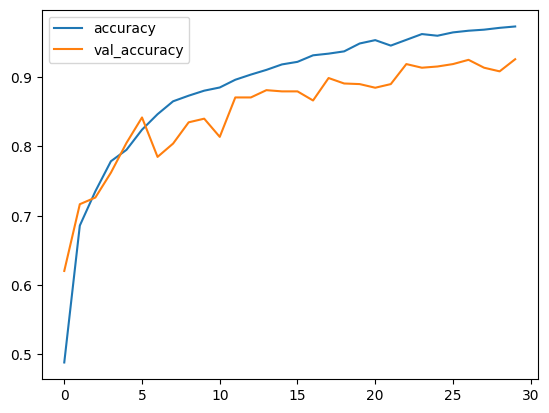

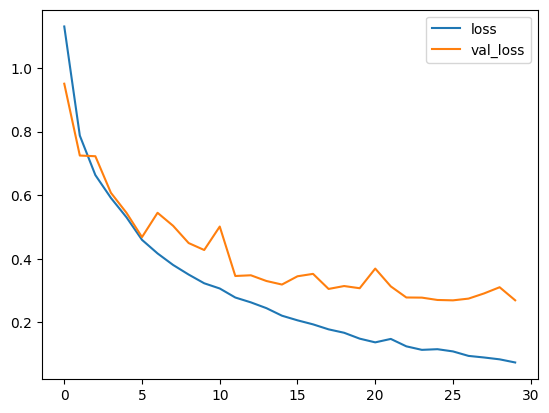

In [34]:
import pandas as pd
ef=pd.DataFrame(history2.history)
ef[['accuracy','val_accuracy']].plot()
ef[['loss','val_loss']].plot()

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

      glioma       0.93      0.90      0.91       264
  meningioma       0.88      0.84      0.85       268
     notumor       0.95      0.97      0.96       319
   pituitary       0.94      0.98      0.96       292

    accuracy                           0.93      1143
   macro avg       0.92      0.92      0.92      1143
weighted avg       0.92      0.93      0.92      1143



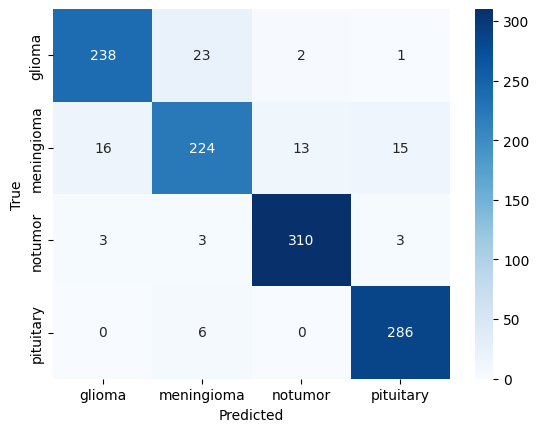

In [36]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=categories))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

      glioma       0.93      0.90      0.91       264
  meningioma       0.88      0.84      0.85       268
     notumor       0.95      0.97      0.96       319
   pituitary       0.94      0.98      0.96       292

    accuracy                           0.93      1143
   macro avg       0.92      0.92      0.92      1143
weighted avg       0.92      0.93      0.92      1143



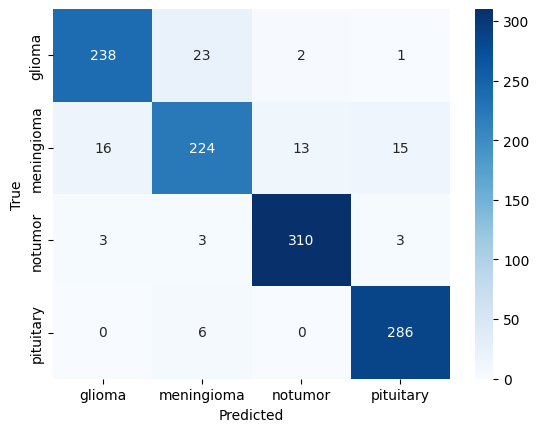

In [38]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=categories))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

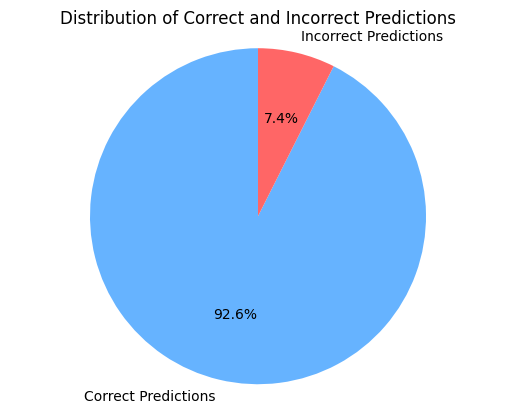

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

correct_predictions = np.sum(y_pred_classes == y_true)
incorrect_predictions = np.sum(y_pred_classes != y_true)

labels = ['Correct Predictions', 'Incorrect Predictions']
sizes = [correct_predictions, incorrect_predictions]
colors = ['#66b3ff', '#ff6666']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Distribution of Correct and Incorrect Predictions')
plt.show()


In [40]:
print("correct prediction : ",correct_predictions)
print("wrong predictions : ",incorrect_predictions)

correct prediction :  1058
wrong predictions :  85


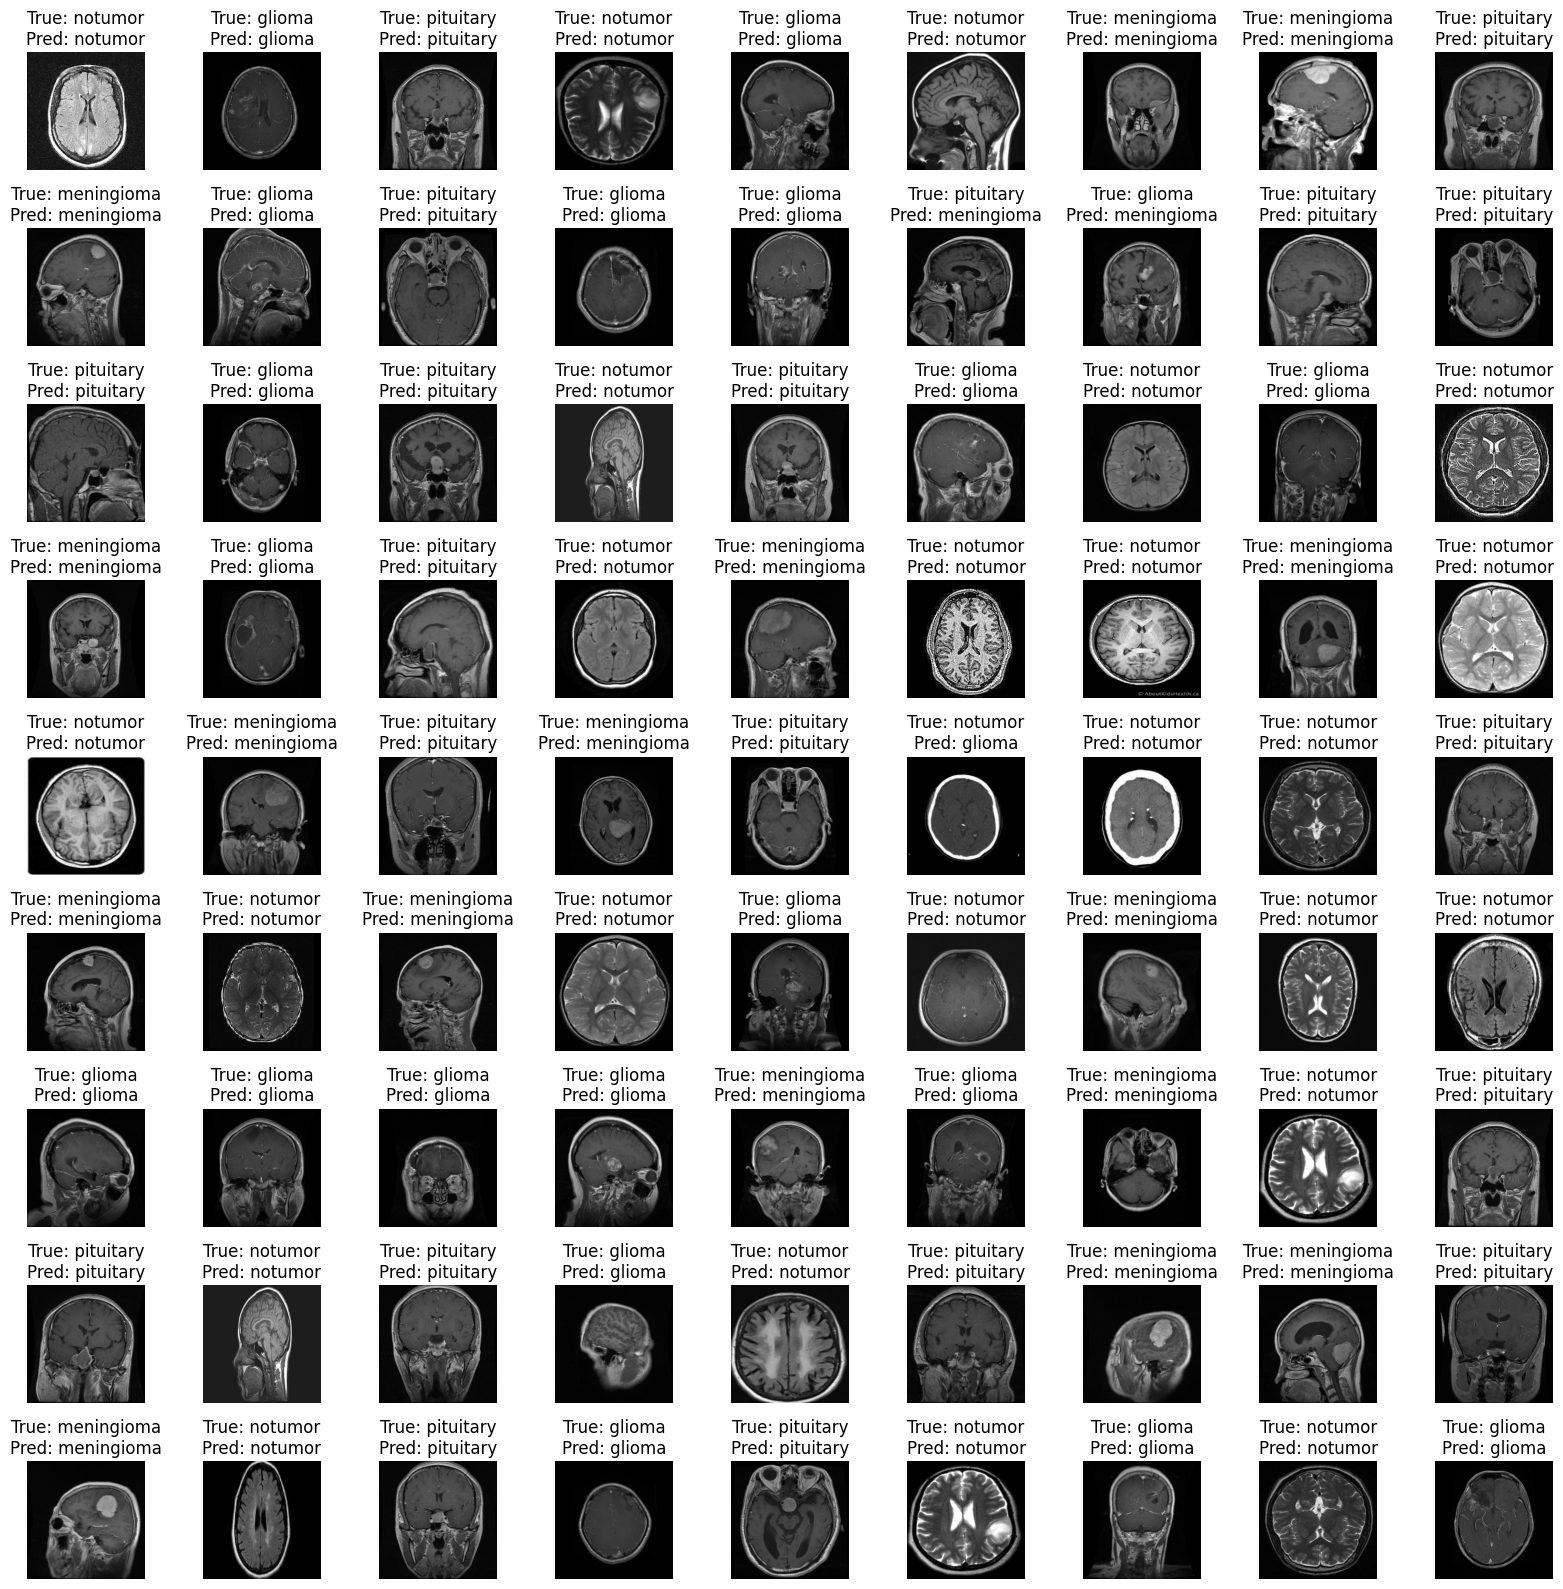

In [41]:
import numpy as np
import matplotlib.pyplot as plt

indices = np.random.choice(x_test.shape[0], 81)
selected_images = x_test[indices]
selected_true_labels = y_test[indices]
selected_pred_labels = y_pred[indices]

selected_true_labels = np.argmax(selected_true_labels, axis=1)
selected_pred_labels = np.argmax(selected_pred_labels, axis=1)

fig, axes = plt.subplots(9, 9, figsize=(16, 16))
axes = axes.ravel()

for i in np.arange(81):
    axes[i].imshow(selected_images[i])
    true_label = categories[selected_true_labels[i]]
    pred_label = categories[selected_pred_labels[i]]
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Explainable AI

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted Class: glioma


100%|██████████| 1000/1000 [00:10<00:00, 98.20it/s]


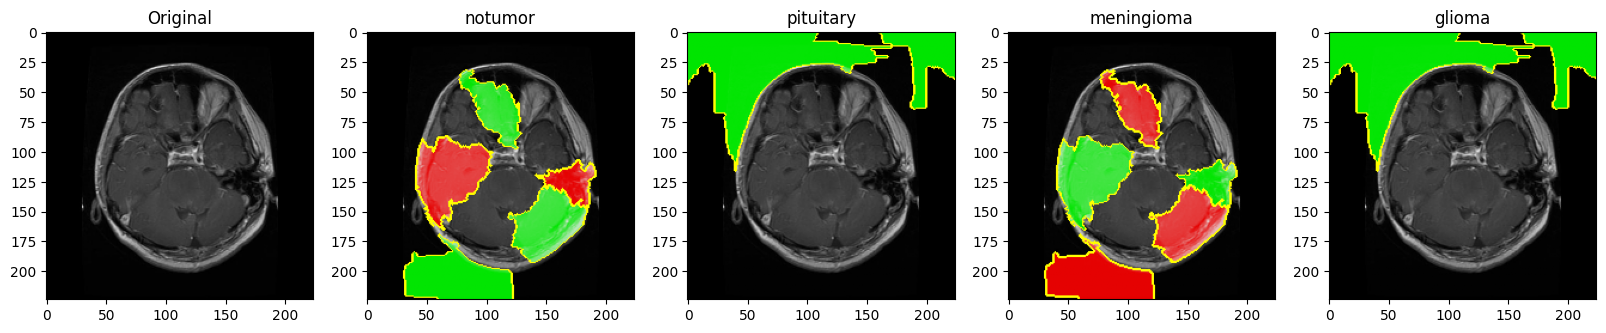

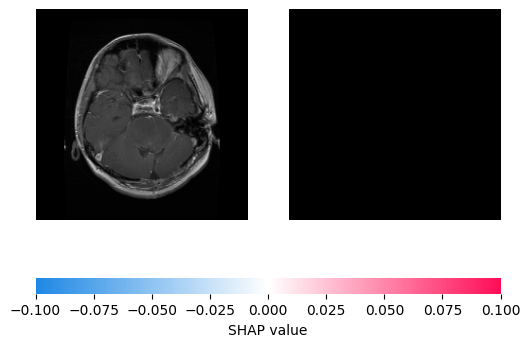

In [32]:
# Explainable AI Section
# Test image path (replace with a valid test image)
TEST_IMAGE_PATH = r"brain2/Testing/glioma/Te-gl_0010.jpg"

def load_and_preprocess_image(img_path, target_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = cv2.resize(img, (target_size, target_size))
    img_tensor = np.array(img_array).astype('float32') / 255.0
    img_tensor_batch = np.expand_dims(img_tensor, axis=0)
    return img_tensor_batch, img_array

def predict_fn(images):
    return model.predict(images, verbose=0)

# Load test image
img_tensor, original_img = load_and_preprocess_image(TEST_IMAGE_PATH, IMG_SIZE)

# Prediction
predictions = model.predict(img_tensor)
predicted_class_idx = np.argmax(predictions[0])
predicted_class = categories[predicted_class_idx]
print(f"Predicted Class: {predicted_class}")

# LIME Explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(original_img, predict_fn, top_labels=4, num_samples=1000)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes[0].imshow(original_img)
axes[0].set_title('Original')
for i, label in enumerate(explanation.top_labels):
    temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=5, hide_rest=False)
    axes[i+1].imshow(mark_boundaries(temp, mask))
    axes[i+1].set_title(categories[label])
plt.show()

# SHAP Explanation
explainer = shap.DeepExplainer(model, img_tensor)
shap_values = explainer.shap_values(img_tensor)
shap.image_plot(shap_values, img_tensor)

Integrated Gradient

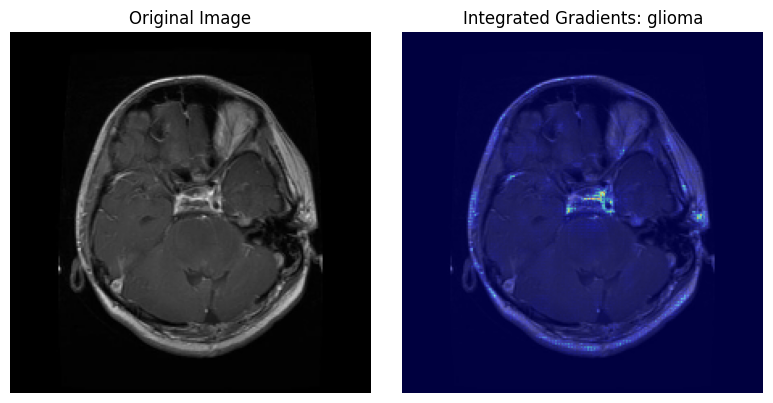

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def integrated_gradients(model, baseline, input_image, class_idx, steps=50):
    # Define the path from baseline to input
    interpolated_images = [
        baseline + (float(i) / steps) * (input_image - baseline) for i in range(steps + 1)
    ]
    interpolated_images = np.array(interpolated_images)
    
    # Compute gradients
    grads = []
    for img in interpolated_images:
        img = tf.convert_to_tensor(img)
        with tf.GradientTape() as tape:
            tape.watch(img)
            preds = model(img)
            loss = preds[:, class_idx]
        grad = tape.gradient(loss, img)
        grads.append(grad)
    
    # Average the gradients
    avg_grads = np.mean(grads, axis=0)
    
    # Compute integrated gradients
    integrated_grads = (input_image - baseline) * avg_grads
    return integrated_grads

# Define a baseline (e.g., black image)
baseline = np.zeros_like(img_tensor)

# Compute Integrated Gradients
integrated_grads = integrated_gradients(model, baseline, img_tensor, predicted_class_idx)

# Convert to visualization
integrated_grads = np.abs(integrated_grads[0]).max(axis=-1)  # Max across channels
integrated_grads = (integrated_grads - integrated_grads.min()) / (integrated_grads.max() - integrated_grads.min())

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(original_img)
plt.imshow(integrated_grads, cmap='jet', alpha=0.5)
plt.title(f"Integrated Gradients: {predicted_class}")
plt.axis('off')
plt.tight_layout()
plt.show()

Saliency Map

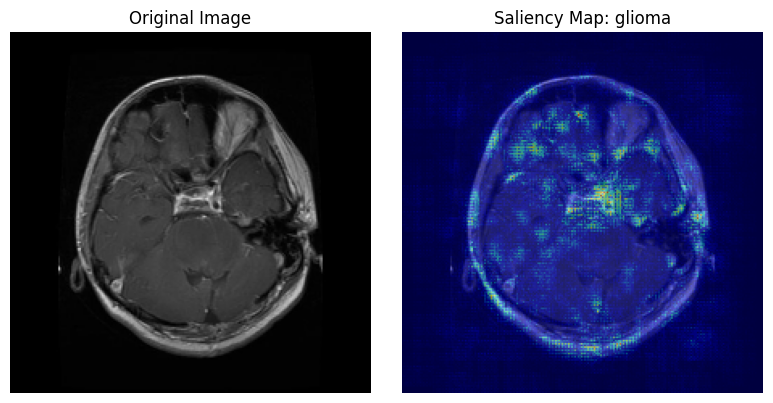

In [46]:
import tensorflow as tf
import matplotlib.pyplot as plt

def compute_saliency_map(model, input_image, class_idx):
    input_image = tf.convert_to_tensor(input_image)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, input_image)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()[0]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    return saliency

# Compute saliency map
saliency_map = compute_saliency_map(model, img_tensor, predicted_class_idx)

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(original_img)
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.title(f"Saliency Map: {predicted_class}")
plt.axis('off')
plt.tight_layout()
plt.show()

Occulsion Sensitivity Ananlysis

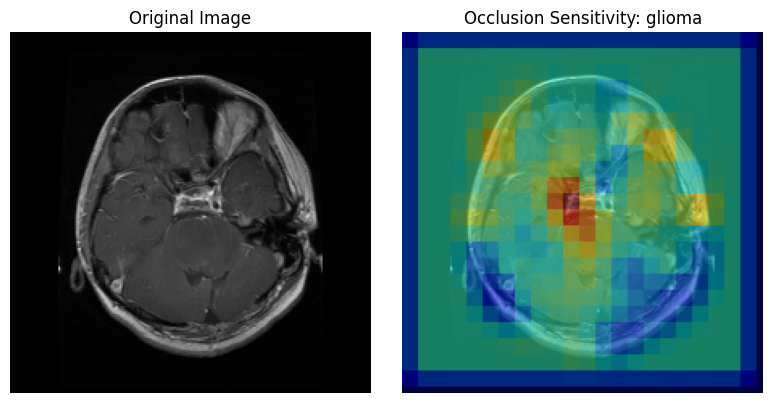

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def occlusion_sensitivity(model, input_image, class_idx, patch_size=20, stride=10):
    height, width = input_image.shape[1:3]
    output = np.zeros((height, width))
    
    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            # Create a copy of the image and occlude a patch
            occluded_image = input_image.copy()
            occluded_image[:, i:i+patch_size, j:j+patch_size, :] = 0
            pred = model.predict(occluded_image, verbose=0)[0, class_idx]
            output[i:i+patch_size, j:j+patch_size] += (1 - pred)  # Drop in confidence
    
    output = (output - output.min()) / (output.max() - output.min())
    return output

# Compute occlusion sensitivity
occlusion_map = occlusion_sensitivity(model, img_tensor, predicted_class_idx)

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(original_img)
plt.imshow(occlusion_map, cmap='jet', alpha=0.5)
plt.title(f"Occlusion Sensitivity: {predicted_class}")
plt.axis('off')
plt.tight_layout()
plt.show()